In [33]:
# -*- coding: utf-8 -*-
"""rise_spatial_multiplicative_norm_zero_cineca.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1-4UndkKCTVbDRQZql3km54NZicEG05gb

### ***Cineca***
"""

import tensorflow as tf
#from tensorflow.keras import layers, activations, callbacks, models
import numpy as np
import pickle
import os
from keras.models import load_model
from skimage.transform import resize
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import sys
import datetime

"""
##### ***Data & Black-Box***

"""

RESULT_DIR = str(sys.argv[1])
print(f"RESULT_DIR: {RESULT_DIR}")

# IMPORTO I DATI PER VOTTIGNASCO
import os

# Ottieni il percorso effettivo da una variabile d'ambiente
work_path = os.environ['WORK']  # Ottieni il valore della variabile d'ambiente WORK
v_test_OHE_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_month_OHE.npy")
v_test_image_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_normalized_image_sequences.npy")
v_test_target_dates_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_target_dates.npy")
v_test_normalization_factors_std_path  = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_std.npy")
v_test_normalization_factors_mean_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_mean.npy")

# Carica l'array numpy dai file
vottignasco_test_OHE    = np.load(v_test_OHE_path)
vottignasco_test_image  = np.load(v_test_image_path)
vottignasco_test_dates  = np.load(v_test_target_dates_path)
vott_target_test_std    = np.load(v_test_normalization_factors_std_path) 
vott_target_test_mean   = np.load(v_test_normalization_factors_mean_path)

print(len(vottignasco_test_dates))
print(len(vottignasco_test_image))
print(len(vottignasco_test_OHE))

#print(vottingasco_test_OHE[0], "\n")
#print(vottignasco_test_image[0][0], "\n")

# """##### ***Black Boxes***""

# Se vuoi abilitare il dropout a runtime
mc_dropout = True

# Definizione della classe personalizzata doprout_custom
class doprout_custom(tf.keras.layers.SpatialDropout1D):
    def call(self, inputs, training=None):
        if mc_dropout:
            return super().call(inputs, training=True)
        else:
            return super().call(inputs, training=False)

# Percorso della directory su Cineca
base_dir = os.path.join(os.environ['WORK'], "Water_Resources/rise-video/trained_models/seq2val/Vottignasco")
lstm_suffix = 'time_dist_LSTM'

vott_lstm_models = []

def extract_index(filename):
    """Funzione per estrarre l'indice finale dal nome del file."""
    return int(filename.split('_LSTM_')[-1].split('.')[0])

# Trova tutti i file .keras nella cartella e li aggiunge alla lista
for filename in os.listdir(base_dir):
    if lstm_suffix in filename and filename.endswith(".keras"):
        vott_lstm_models.append(os.path.join(base_dir, filename))

# Ordina i modelli in base all'indice finale
vott_lstm_models = sorted(vott_lstm_models, key=lambda x: extract_index(os.path.basename(x)))

# Lista per i modelli caricati
vott_lstm_models_loaded = []

for i, model_lstm_path in enumerate(vott_lstm_models[:10]):  # Prendo i primi 10 modelli ordinati
    #print(f"Caricamento del modello LSTM {i+1}: {model_lstm_path}")

    # Carico il modello con la classe custom
    model = load_model(model_lstm_path, custom_objects={"doprout_custom": doprout_custom})

    # Aggiungo il modello alla lista
    vott_lstm_models_loaded.append(model)

print(vott_lstm_models_loaded)

### ***Temporal-RISE***

#### ***Generation Masks (1D): Uniforme***

import numpy as np
from tqdm import tqdm

def generate_masks_1d(N, input_size, seed=42, **kwargs):
    """
    Parametri:
    - input_size: è il nr di time-step -> scalare
    """
    l = kwargs.get("l", 3)  # La lunghezza della small_mask
    p1 = kwargs.get("p1", 0.5)  # Probabilità di attivazione della maschera

    np.random.seed(seed)

    # Genera una maschera 1D casuale (lunghezza = small_mask_length)
    grid = np.random.rand(N, l) < p1
    grid = grid.astype('float32')  # Trasforma in formato float32

    # Crea una struttura per le maschere finali
    masks = np.empty((N, input_size))  # Maschere finali di dimensione (N, H)

    for i in tqdm(range(N), desc='Generating masks'):
        # Calcola i punti di interpolazione
        x = np.linspace(0, l - 1, l)  # Indici della maschera piccola
        new_x = np.linspace(0, l - 1, input_size)  # Nuovi punti per la dimensione H

        # Interpolazione 1D
        interpolated_mask = np.interp(new_x, x, grid[i])  # Interpola la maschera

        # Applica la maschera interpolata alla maschera finale
        masks[i, :] = interpolated_mask

    # Filtra le maschere che sono tutte 0.0
    masks = masks[~(masks == 0).all(axis=1)]  # Filtra lungo l'asse della dimensione 1 (H)

    return masks

#### ***Application Masks***

def multiplicative_uniform_noise_onechannel(images, masks, channel, **kwargs):
    std_zero_value = kwargs.get("std_zero_value", -0.6486319166678826)

    masked = []

    # Itero su tutte le N maschere generate
    for mask in masks:
        masked_images = copy.deepcopy(images)  # Copia profonda delle immagini originali

        for t in range(len(mask)):
          masked_images[t][..., channel] = masked_images[t][..., channel] * mask[t] + (1-mask[t]) * std_zero_value

        masked.append(masked_images)

    return masked

#### ***Prediction with Black-Box***
def ensemble_predict(models, images, x3_exp, batch_size=1000):
    # Assicuriamoci che images sia una lista
    if not isinstance(images, list):
        images = [images]

    len_x3 = len(images)

    # Convertiamo x3_exp in un tensore replicato per ogni immagine
    x3_exp_tensor = tf.convert_to_tensor(x3_exp, dtype=tf.float32)

    # Lista per raccogliere le predizioni finali
    final_preds = []

    # Processamento a batch
    for i in range(0, len_x3, batch_size):
        batch_images = images[i:i + batch_size]
        batch_len = len(batch_images)

        # Conversione batch in tensori
        Y_test = tf.stack([tf.convert_to_tensor(img, dtype=tf.float32) for img in batch_images])
        Y_test_x3 = tf.tile(tf.expand_dims(x3_exp_tensor, axis=0), [batch_len, 1, 1])

        # Raccoglie le predizioni di tutti i modelli per il batch corrente
        batch_preds = []

        for model in models:
            preds = model.predict([Y_test, Y_test_x3], verbose=0)
            batch_preds.append(preds)

        # Converte le predizioni del batch in un tensore e calcola la media
        batch_preds_tensor = tf.stack(batch_preds)
        mean_batch_preds = tf.reduce_mean(batch_preds_tensor, axis=0)

        # Aggiunge le predizioni del batch alla lista finale
        final_preds.extend(mean_batch_preds.numpy())

    return np.array(final_preds)

#### ***Saliency Map***
def calculate_saliency_map(N, weights, masks):
    """
    Calcola la mappa di salienza media data una serie di predizioni e maschere.

    :param weights: Array di predizioni (numero di maschere x dimensioni predizione).
    :param masks: Array di maschere (numero di maschere x dimensioni maschera).
    :return: Mappa di salienza media.
    """
    sal = []
    for j in range(len(masks)):
        sal_i = weights[j] * masks[j]
        sal.append(sal_i)

    ev_masks = np.mean(masks, axis=0)
    
    sal = (1/(ev_masks*N)) * np.sum(sal, axis=0)  # aggiunta della frazione 1/valore_atteso(maschere)
    return sal

"""#### ***Temporal-RISE: Framework***"""

def rise_temporal_explain(nr_instance, data_test_image, data_test_OHE, models, channel,
                          N, generate_masks_fn, seed, perturb_instance_fn, calculate_saliency_map_fn, H_station=390.0, **kwargs):
  print(f"############################### RISE-Temporal on Instance #{nr_instance} ###########################")
  instance    = copy.deepcopy(data_test_image[nr_instance])
  x3_instance = copy.deepcopy(data_test_OHE[nr_instance])

  input_size = instance.shape[0]
  
  masks = generate_masks_fn(N, input_size, seed, **kwargs)
  perturbed_instances = perturb_instance_fn(instance, masks, channel)

  # Predizione su Istanza Originale
  pred_original = ensemble_predict(models, instance, x3_instance)
  # Predizioni su Istanze Perturbate
  preds_masked = ensemble_predict(models, perturbed_instances, x3_instance)

  # Denormalizzazione Output Black-Box con H_station 
  denorm_pred_original = (pred_original * vott_target_test_std) + vott_target_test_mean
  denorm_preds_masked  = [(pred_masked * vott_target_test_std) + vott_target_test_mean for pred_masked in preds_masked]
  denormalized_H_pred_original = H_station - denorm_pred_original
  denormalized_H_preds_masked  = [H_station - denorm_pred_masked for denorm_pred_masked in denorm_preds_masked]
  # Pesi delle Maschere
  weights = np.concatenate(denormalized_H_preds_masked, axis=0)

  ### S1 
  s1_i = calculate_saliency_map_fn(N, weights, masks)
  ### S2
  s2_i = calculate_saliency_map_fn(N, weights**2, masks) - (s1_i**2)
  ### S3 (BIAS)
  s3_i = (s1_i - denormalized_H_pred_original)
  ### S4 (RMSE)
  s4_i = np.sqrt((s3_i**2) + s2_i)
  print(f"############### Processo completato. Vettore di salienza generata per Istanza #{nr_instance} ###############")
  
  return np.squeeze(s1_i), np.squeeze(s2_i), np.squeeze(s3_i), np.squeeze(s4_i)

#### ***Evaluation Metric***

# Ho implementato anche qui l'approccio a batch per migliorare i tempi di exec

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def calculate_auc(x, y):
    """
    Calcola l'area sotto la curva (AUC) utilizzando il metodo del trapezio.

    :param x: Valori dell'asse x (frazione dei pixel inseriti).
    :param y: Valori dell'asse y (errori calcolati).
    :return: Area sotto la curva.
    """
    return np.trapz(y, x)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def update_image_with_important_frame(current_instance, original_instance, t):
    """
    Aggiorna la current_instance inserendo il t-esimo frame.

    :param current_instance: istanza corrente.
    :param original_instance: istanza originale.
    :param t: nr di frame da inserire in current_instance
    :return: istanza aggiornata.
    """
    new_instance = copy.deepcopy(current_instance)
    new_instance[t,:,:,0] = original_instance[t,:,:,0]
    return new_instance


def insertion(models, original_images, x3, important_indices, initial_blurred_images, original_prediction, H_station=390.0):
    """
    Calcola la metrica di inserimento per una spiegazione data.

    :param models: Lista di modelli pre-addestrati.
    :param original_images: Immagine originale.
    :param x3: Codifica one-hot per la previsione.
    :param important_indices: Indici dei pixel in ordine di importanza.
    :param initial_blurred_images: Immagine iniziale con tutti i pixel a zero.
    :return: Lista degli errori ad ogni passo di inserimento.
    """

    # Predizione originale
    #original_prediction = ensemble_predict(models, original_images, x3)[0]
    #print("Original prediction:", original_prediction)

    # Lista per memorizzare le istanze a cui aggiungo frame mano a mano
    insertion_images = [initial_blurred_images]

    # Predizione sull'immagine iniziale (tutti i pixel a zero)
    I_prime = initial_blurred_images.copy()

    # Aggiungere gradualmente i frames più importanti. Ottengo una lista con tutte le img con i frame in maniera graduale
    for t in important_indices:
        #print(frame)
        I_prime = update_image_with_important_frame(I_prime, original_images, t)
        insertion_images.append(I_prime)

    # Calcolo le predizioni sulle istanze a cui ho aggiunto i frame in maniera graduale
    new_predictions = ensemble_predict(models, insertion_images, x3)
    denorm_new_predictions  = [new_prediction * vott_target_test_std + vott_target_test_mean for new_prediction in new_predictions]
    denormalized_H_new_predictions  = [H_station - denorm_new_prediction for denorm_new_prediction in denorm_new_predictions]
    # Rispetto ad ogni suddetta predizione, calcolo il MSE rispetto la pred sull'istanza originaria (come da test-set)
    errors = [mean_squared_error(original_prediction, masked_pred) for masked_pred in denormalized_H_new_predictions[1:]]

    initial_error = mean_squared_error(original_prediction, denormalized_H_new_predictions[0]) # mse immagine con tutti i frame blurrati
    print(f"Initial Prediction with ALL Blurred Frame, pred: {denormalized_H_new_predictions[0]}, error: {initial_error}")
    only_inserted_frame_new_predictions = denormalized_H_new_predictions[1:]
    for t, error in enumerate(errors):
      print(f"Frame {important_indices[t]}, new prediction: {only_inserted_frame_new_predictions[t]}, error: {error}")

    total_errors = [initial_error] + errors
    # Normalizzare la frazione di pixel inseriti
    x = np.linspace(0, 1, len(total_errors))
    print("len total erros: ", len(total_errors))

    # Calcolo dell'AUC
    auc = calculate_auc(x, total_errors)
    print(f"Area under the curve (AUC): {auc}")

    # # Plot della curva dell'errore e area sotto la curva (AUC)
    # plt.plot(x, total_errors, label='Error curve')
    # plt.fill_between(x, total_errors, color='skyblue', alpha=0.4)
    # plt.text(x[-1] * 0.95, max(total_errors) * 0.9, f'AUC: {auc:.2f}',
    #      horizontalalignment='right')  # testo a destra
    # plt.xlabel('Fraction of pixels inserted')
    # plt.ylabel('Mean Squared Error')
    # plt.title('Insertion Metric Curve')
    # plt.legend()
    # plt.show()
    return total_errors,auc

def update_image_by_removing_frame(current_instance, t, std_zero_value=-0.6486319166678826):
    """
    Aggiorna l'immagine inserendo i pixel più importanti.

    :param current_instance: Istanza corrente.
    :param original_instance: Istanza originale.
    :param t: nr frame da rimuovere.
    :return: Istanza aggiornata con il superpixel.
    """
    new_current_instance = current_instance.copy()
    new_current_instance[t,:,:,0] = std_zero_value
    return new_current_instance

def deletion(models, original_images, x3, important_indices, original_prediction, H_station=390.0):
    """
    Calcola la metrica di rimozione per una spiegazione data.

    :param models: Lista di modelli pre-addestrati.
    :param original_images: Immagine originale.
    :param x3: Codifica one-hot per la previsione.
    :param important_indices: Indici dei pixel in ordine di importanza.
    :return: Lista degli errori ad ogni passo di rimozione.
    """

    # Lista per memorizzare le img a cui elimino gradualmente frames
    deletions_images = []

    # Inizializzazione
    I_prime = original_images.copy()

    # Rimuovere gradualmente i frames più importanti
    for t in important_indices:
        I_prime = update_image_by_removing_frame(I_prime, t)
        deletions_images.append(I_prime)

    # Calcolo della predizione su tutte le img a cui rimuovo gradualmente in frames
    new_predictions = ensemble_predict(models, deletions_images, x3)
    denorm_new_predictions  = [new_prediction * vott_target_test_std + vott_target_test_mean for new_prediction in new_predictions]
    denormalized_H_new_predictions  = [H_station - denorm_new_prediction for denorm_new_prediction in denorm_new_predictions]
    # Calcolo del mse rispetto la predizione originale
    errors = [mean_squared_error(original_prediction, masked_pred) for masked_pred in denormalized_H_new_predictions]

    initial_error = 0.0
    print(f"Initial Prediction with Original Images, prediction: {original_prediction}, error: {initial_error}")
    for t, error in enumerate(errors):
      print(f"Removed frame {important_indices[t]}, new prediction: {denormalized_H_new_predictions[t]}, error: {error}")

    total_errors = [initial_error] + errors # Errore iniziale + errori su tutti i pixel rimossi

    # Normalizzare la frazione di pixel rimossi
    x = np.arange(len(total_errors)) / len(total_errors)

    # Calcolo dell'AUC
    auc = calculate_auc(x, total_errors)
    print(f"Area under the curve (AUC): {auc}")

    # # Plot della curva dell'errore e area sotto la curva (AUC)
    # plt.plot(x, total_errors, label='Error curve')
    # plt.fill_between(x, total_errors, color='lightcoral', alpha=0.4)
    # # Posiziona il testo AUC alla destra del titolo
    # plt.text(1.02, 1.02, f'AUC: {auc:.2f}',
    #      horizontalalignment='left',
    #      transform=plt.gca().transAxes,  # Coordinate rispetto all'asse (da 0 a 1)
    #      fontsize=11)
    # plt.xlabel('Fraction of pixels removed')
    # plt.ylabel('Mean Squared Error')
    # plt.title('Deletion Metric Curve')
    # plt.legend()
    # plt.show()
    return total_errors,auc

RESULT_DIR: --f=/run/user/129071/jupyter/runtime/kernel-v34fc03483f14d37229cd42b82f1fc2a4b34247839.json
105
105
105
[<keras.src.engine.functional.Functional object at 0x7f879df9b280>, <keras.src.engine.functional.Functional object at 0x7f878b5df610>, <keras.src.engine.functional.Functional object at 0x7f878b806b90>, <keras.src.engine.functional.Functional object at 0x7f878b8065c0>, <keras.src.engine.functional.Functional object at 0x7f878ba4e0e0>, <keras.src.engine.functional.Functional object at 0x7f878b9de650>, <keras.src.engine.functional.Functional object at 0x7f878baf7130>, <keras.src.engine.functional.Functional object at 0x7f878bbd4cd0>, <keras.src.engine.functional.Functional object at 0x7f879c797880>, <keras.src.engine.functional.Functional object at 0x7f879c84b3d0>]


In [21]:
channel_prec = 0
models = vott_lstm_models_loaded
seed = 42
T,H,W,C = (104,5,8,3)
std_zero_value = -0.6486319166678826
H_station = 390.0

N = 1000

#l_values = [2,4,8,9,10,11,12,13,14,18]
l_values = [12]
#p_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
p_values = [0.5]

len_test_set = len(vottignasco_test_image)

############# mock 
mock_vott_test_image = [copy.deepcopy(vottignasco_test_image[0])]
len_test_set = len(mock_vott_test_image)

for nr_setup,l in enumerate(l_values):
  print(f"############################## Setup #{nr_setup} ##############################")
  for nr_p, p in enumerate(p_values):
    # Conserva tutte i sal_vecs per tutto il Test-Set
    saliency_vectors = np.zeros((len_test_set,4,T))

    # Errori e AUC Insertion/Deletion tutto il Test-Set
    errors_insertion_all_testset = np.zeros((len_test_set,4, T+1))   # (105, 105)
    auc_insertion_all_testset    = np.zeros((len_test_set,4, 1))     # (105, 1)
    errors_deletion_all_testset  = np.zeros((len_test_set,4, T+1))   # (105, 105)
    auc_deletion_all_testset     = np.zeros((len_test_set,4, 1))     # (105, 1)

    param_combination = f"l_{l}_p_{nr_p+1}"

    execution_times = []

    print(f"############################## Parameters Combination: {param_combination} ##############################")
    #for nr_instance,_ in enumerate(vottignasco_test_image):
    for nr_instance,_ in enumerate(mock_vott_test_image):
       print(f"###################### Explanation for Instance #{nr_instance} ####################################")
       time_start = datetime.datetime.now()

       s1_i,s2_i,s3_i,s4_i = rise_temporal_explain(nr_instance, vottignasco_test_image, vottignasco_test_OHE, models, channel_prec,
                                                N, generate_masks_1d, seed, multiplicative_uniform_noise_onechannel, calculate_saliency_map, H_station, l=l, p1=p)

       time_end = datetime.datetime.now()
       exec_time = (time_end - time_start).total_seconds()
       execution_times.append(exec_time)

       saliency_vectors[nr_instance][0] = s1_i
       saliency_vectors[nr_instance][1] = s2_i
       saliency_vectors[nr_instance][2] = s3_i
       saliency_vectors[nr_instance][3] = s4_i

       instance    = copy.deepcopy(vottignasco_test_image[nr_instance])
       x3_instance = copy.deepcopy(vottignasco_test_OHE[nr_instance])

       # Insertion s2,s3,s4
       # Video blurrato da cui partire per l'Insertion. Tutti i pixel di Prec su std_zero_value
       initial_blurred_instance = copy.deepcopy(instance)
       initial_blurred_instance[:,:,:,channel_prec] = std_zero_value

       original_instance = copy.deepcopy(instance)
       original_prediction = ensemble_predict(models, original_instance, x3_instance)
       denormalized_H_original_prediction = H_station - (original_prediction * vott_target_test_std + vott_target_test_mean)
       print(f"Original Prediction: {denormalized_H_original_prediction}")

       all_important_frames_s2 = np.argsort(s2_i)[:] # Importanza max per valori prossimi allo 0
       all_important_frames_s3 = np.argsort(np.abs(s3_i))[:] # Importanza max per valori prossimi allo 0
       all_important_frames_s4 = np.argsort(s4_i)[:] # Importanza max per valori prossimi allo 0
    
       # Insertion
       errors_insertion_s2,auc_insertion_s2 = insertion(models, original_instance, x3_instance, all_important_frames_s2, initial_blurred_instance, denormalized_H_original_prediction) # s2   
       errors_insertion_s3,auc_insertion_s3 = insertion(models, original_instance, x3_instance, all_important_frames_s3, initial_blurred_instance, denormalized_H_original_prediction) # s3
       errors_insertion_s4,auc_insertion_s4 = insertion(models, original_instance, x3_instance, all_important_frames_s4, initial_blurred_instance, denormalized_H_original_prediction) # s4

       for nr_error in range (0, (T+1)):
         errors_insertion_all_testset[nr_instance][1][nr_error] = errors_insertion_s2[nr_error]
         errors_insertion_all_testset[nr_instance][2][nr_error] = errors_insertion_s3[nr_error]
         errors_insertion_all_testset[nr_instance][3][nr_error] = errors_insertion_s4[nr_error]

       auc_insertion_all_testset[nr_instance][1] = auc_insertion_s2
       auc_insertion_all_testset[nr_instance][2] = auc_insertion_s3
       auc_insertion_all_testset[nr_instance][3] = auc_insertion_s4

       #Deletion
       errors_deletion_s2,auc_deletion_s2 = deletion(models, original_instance, x3_instance, all_important_frames_s2, denormalized_H_original_prediction) # s2
       errors_deletion_s3,auc_deletion_s3 = deletion(models, original_instance, x3_instance, all_important_frames_s3, denormalized_H_original_prediction) # s3
       errors_deletion_s4,auc_deletion_s4 = deletion(models, original_instance, x3_instance, all_important_frames_s4, denormalized_H_original_prediction) # s4

       for nr_error in range (0, (T+1)):
         errors_deletion_all_testset[nr_instance][1][nr_error] = errors_deletion_s2[nr_error]
         errors_deletion_all_testset[nr_instance][2][nr_error] = errors_deletion_s3[nr_error]
         errors_deletion_all_testset[nr_instance][3][nr_error] = errors_deletion_s4[nr_error]

       auc_deletion_all_testset[nr_instance][1] = auc_deletion_s2
       auc_deletion_all_testset[nr_instance][2] = auc_deletion_s3
       auc_deletion_all_testset[nr_instance][3] = auc_deletion_s4

    print(f"#################################### END for all Instance in Test-Set for {param_combination} ####################################")
    
    result = {
                "saliency_vectors": saliency_vectors,
                "errors_insertion": errors_insertion_all_testset,
                "auc_insertion": auc_insertion_all_testset,
                "errors_deletion": errors_deletion_all_testset,
                "auc_deletion": auc_deletion_all_testset,
                "parameters_comb": param_combination,
                "execution_times": execution_times  # Lista di nr_instances (105) tempi di exec per ogni istanza
            }
    
    path_to_save_results = os.path.join(work_path, f"Water_Resources/rise-video/XAI/temporal/results/test_{param_combination}.pkl")
    #path_to_save_results = f"{RESULT_DIR}/rise_temporal_original_result_setup_{param_combination}.pkl"
    # Salvataggio della lista results in un file pickle
    with open(path_to_save_results, 'wb') as f:
      pickle.dump(result, f)

print("############################# END FOR ALL SETUPS ##########################################################################")

############################## Setup #0 ##############################
############################## Parameters Combination: l_12_p_1 ##############################
###################### Explanation for Instance #0 ####################################
############################### RISE-Temporal on Instance #0 ###########################


Generating masks: 100%|██████████| 1000/1000 [00:00<00:00, 27047.46it/s]


############### Processo completato. Vettore di salienza generata per Istanza #0 ###############
Original Prediction: [[385.44107]]
Initial Prediction with ALL Blurred Frame, pred: [384.13754], error: 1.699184775352478
Frame 28, new prediction: [384.1403], error: 1.6920318603515625
Frame 29, new prediction: [383.9443], error: 2.2403059005737305
Frame 30, new prediction: [383.98303], error: 2.12587571144104
Frame 27, new prediction: [384.129], error: 1.7215349674224854
Frame 31, new prediction: [384.02573], error: 2.003199338912964
Frame 32, new prediction: [383.97128], error: 2.16027569770813
Frame 26, new prediction: [384.11996], error: 1.7453209161758423
Frame 33, new prediction: [384.04648], error: 1.944887638092041
Frame 34, new prediction: [384.08646], error: 1.834979772567749
Frame 35, new prediction: [383.9416], error: 2.248443841934204
Frame 25, new prediction: [384.1586], error: 1.644731044769287
Frame 36, new prediction: [383.94986], error: 2.223710060119629
Frame 37, new pre

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_auc(x, y):
    """
    Calcola l'area sotto la curva (AUC) utilizzando il metodo del trapezio.

    :param x: Valori dell'asse x (frazione dei pixel/frame inseriti).
    :param y: Valori dell'asse y (errori calcolati).
    :return: Area sotto la curva.
    """
    return np.trapz(y, x)

def plot_combined_curves(all_errors_insertion, all_errors_deletion, title="", save_path=""):
    # Creazione della figura e dei due subplot (1 riga, 2 colonne)
    fig, axs = plt.subplots(1, 2, figsize=(11, 5))

    # Plot per la curva di inserimento
    max_len_insertion = max(map(len, all_errors_insertion))
    padded_array_insertion = np.full((len(all_errors_insertion), max_len_insertion), np.nan)
    for i, row in enumerate(all_errors_insertion):
        padded_array_insertion[i, :len(row)] = row  # Riempie solo le parti esistenti
    #mean_errors_for_insertion_vott = np.nanmean(all_errors_insertion, axis=0)
    mean_errors_for_insertion_vott = np.nanmean(padded_array_insertion, axis=0)

    #x_insertion = np.arange(0, mean_errors_for_insertion_vott.shape[0])
    x_insertion = np.linspace(0, 1, mean_errors_for_insertion_vott.shape[0])
    auc_insertion = calculate_auc(x_insertion, mean_errors_for_insertion_vott)
    auc_text_insertion = f'AUC = {auc_insertion:.2f}'
    axs[0].plot(x_insertion, mean_errors_for_insertion_vott, label=f'Error Curve, {auc_text_insertion}')
    #axs[0].scatter(x_insertion, mean_errors_for_insertion_vott, color='blue', zorder=3)


    axs[0].fill_between(x_insertion, mean_errors_for_insertion_vott, color='skyblue', alpha=0.4)
    axs[0].set_xlabel('Fraction of pixels inserted')
    axs[0].set_ylabel('Mean Squared Error')
    axs[0].grid(True, linestyle='--', alpha=0.6)
    axs[0].set_title('Mean Insertion Metric Curve')
    axs[0].legend()

    # Plot per la curva di cancellazione
    max_len_deletion = max(map(len, all_errors_deletion))
    padded_array_deletion = np.full((len(all_errors_deletion), max_len_deletion), np.nan)
    for i, row in enumerate(all_errors_deletion):
        padded_array_deletion[i, :len(row)] = row  # Riempie solo le parti esistenti
    mean_errors_for_deletion_vott = np.nanmean(padded_array_deletion, axis=0)
    #mean_errors_for_deletion_vott = np.nanmean(all_errors_deletion, axis=0)

    #x_deletion = np.arange(0, mean_errors_for_deletion_vott.shape[0])
    x_deletion = np.linspace(0, 1, mean_errors_for_deletion_vott.shape[0])
    auc_deletion = calculate_auc(x_deletion, mean_errors_for_deletion_vott)
    auc_text_deletion = f'AUC = {auc_deletion:.2f}'

    axs[1].plot(x_deletion, mean_errors_for_deletion_vott, label=f'Error Curve, {auc_text_deletion}')
    #axs[1].scatter(x_deletion, mean_errors_for_deletion_vott, color='red', zorder=3)
    axs[1].fill_between(x_deletion, mean_errors_for_deletion_vott, color='lightcoral', alpha=0.4)
    axs[1].set_xlabel('Fraction of pixels removed')
    axs[1].set_ylabel('Mean Squared Error')
    axs[1].grid(True, linestyle='--', alpha=0.6)
    axs[1].set_title('Deletion Mean Metric Curve')
    axs[1].legend()

    # Aggiungi il titolo globale
    plt.suptitle(title, fontsize=16)
    # Mostra i plot
    plt.tight_layout()

    # Salva la figura con DPI 400
    #plt.tight_layout()
    #plt.subplots_adjust(top=0.85)  # Per evitare che il titolo si sovrapponga ai grafici
    #plt.savefig(save_path, dpi=400)

    plt.show()

    return auc_insertion, auc_deletion

In [23]:
path_to_load_results = path_to_save_results = os.path.join(work_path, f"Water_Resources/rise-video/XAI/temporal/results/test_{param_combination}.pkl")
# Load della lista results
with open(path_to_load_results, 'rb') as file:
    result = pickle.load(file)

In [24]:
result["saliency_vectors"][0][3]

array([385.25171933, 385.25171933, 385.25171933, 385.25171933,
       385.25171933, 385.25171933, 385.25171933, 385.25171933,
       385.25171933, 385.25171933, 385.25171933, 385.25171933,
       385.25171933, 385.25171933, 385.25171933, 385.25171933,
       385.25171933, 385.25171933, 385.25171933, 385.25171933,
       385.25171933, 385.25171934, 385.25171934, 385.25171935,
       385.25171935, 385.25171936, 385.25171936, 385.25171937,
       385.25171937, 385.25171937, 385.25171937, 385.25171936,
       385.25171936, 385.25171936, 385.25171935, 385.25171935,
       385.25171935, 385.25171934, 385.25171934, 385.25171934,
       385.25171934, 385.25171934, 385.25171934, 385.25171934,
       385.25171934, 385.25171934, 385.25171934, 385.25171934,
       385.25171934, 385.25171933, 385.25171933, 385.25171932,
       385.25171932, 385.25171931, 385.25171931, 385.2517193 ,
       385.2517193 , 385.2517193 , 385.2517193 , 385.25171931,
       385.25171931, 385.25171931, 385.25171932, 385.25

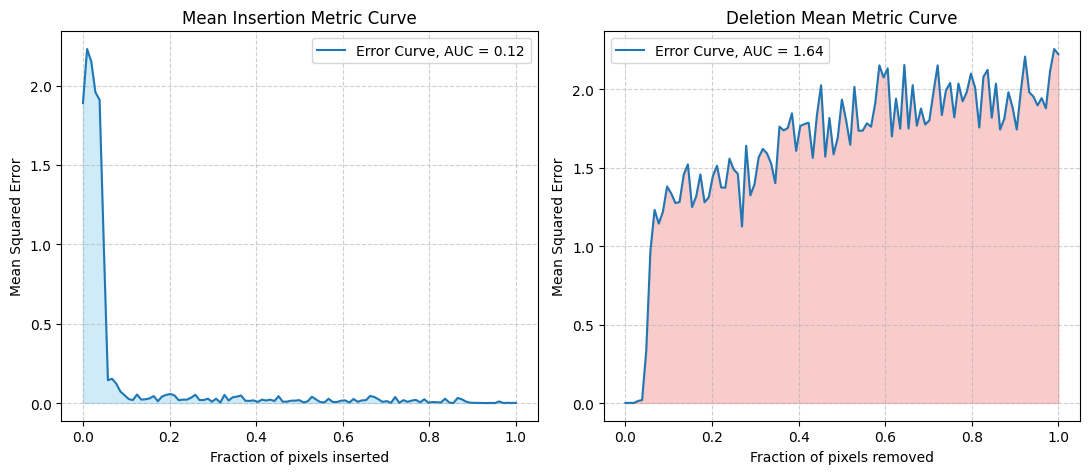

(0.11972426137295912, 1.6417716175604324)

In [28]:
errors_insertion_s3 = result["errors_insertion"][0][2]
errors_deletion_s3  = result["errors_deletion"][0][2]

plot_combined_curves([errors_insertion_s3], [errors_deletion_s3])

In [26]:
errors_deletion_s3

array([0.00000000e+00, 1.25751272e-03, 2.19974667e-04, 1.30687989e-02,
       1.88425221e-02, 3.33734691e-01, 9.69354689e-01, 1.23098373e+00,
       1.14393628e+00, 1.21909416e+00, 1.38052464e+00, 1.33578515e+00,
       1.27456713e+00, 1.28153622e+00, 1.45545137e+00, 1.52119648e+00,
       1.24940383e+00, 1.31722689e+00, 1.45721912e+00, 1.27974033e+00,
       1.31037092e+00, 1.44640851e+00, 1.51240158e+00, 1.37379169e+00,
       1.37336254e+00, 1.55769718e+00, 1.48907328e+00, 1.46127427e+00,
       1.12579560e+00, 1.64019430e+00, 1.32374966e+00, 1.39447212e+00,
       1.56517148e+00, 1.61985588e+00, 1.59124124e+00, 1.52647054e+00,
       1.40147209e+00, 1.76180899e+00, 1.73783004e+00, 1.75339365e+00,
       1.84715378e+00, 1.60737324e+00, 1.76651096e+00, 1.77829325e+00,
       1.78701282e+00, 1.56272888e+00, 1.83497977e+00, 2.02563572e+00,
       1.57029164e+00, 1.81741142e+00, 1.58547199e+00, 1.69107926e+00,
       1.93426228e+00, 1.80435205e+00, 1.64621866e+00, 2.01522493e+00,
      

In [23]:
data_test_image = vottignasco_test_image
data_test_OHE   = vottignasco_test_OHE

l = 12
p = 0.5

channel = 0

input_size = 104

N = 1000

nr_instance = 0
seed = 42
H_station = 390.0
models = vott_lstm_models_loaded

instance    = copy.deepcopy(data_test_image[nr_instance])
x3_instance = copy.deepcopy(data_test_OHE[nr_instance])
input_size = instance.shape[0]

masks = generate_masks_1d(N, input_size, seed, l=l, p=p)
perturbed_instances = multiplicative_uniform_noise_onechannel(instance, masks, channel)
# Predizione su Istanza Originale
pred_original = ensemble_predict(models, instance, x3_instance)
# Predizioni su Istanze Perturbate
preds_masked = ensemble_predict(models, perturbed_instances, x3_instance)
# Denormalizzazione Output Black-Box con H_station 
denorm_pred_original = (pred_original * vott_target_test_std) + vott_target_test_mean
denorm_preds_masked  = [(pred_masked * vott_target_test_std) + vott_target_test_mean for pred_masked in preds_masked]
denormalized_H_pred_original = H_station - denorm_pred_original
denormalized_H_preds_masked  = [H_station - denorm_pred_masked for denorm_pred_masked in denorm_preds_masked]


Generating masks: 100%|██████████| 1000/1000 [00:00<00:00, 17961.22it/s]


In [24]:
print("Pred original: ", pred_original)
print("Pred Original Denorm: ", denormalized_H_pred_original)

Pred original:  [[0.14675477]]
Pred Original Denorm:  [[385.46286]]


In [25]:
print("Preds_masked:", preds_masked)

Preds_masked: [[1.4666876 ]
 [0.24803567]
 [1.9180148 ]
 [1.4522442 ]
 [0.43418998]
 [1.6951876 ]
 [0.35544896]
 [1.6887381 ]
 [1.4072373 ]
 [2.0175025 ]
 [0.34494826]
 [0.36086348]
 [1.7101336 ]
 [0.439927  ]
 [1.588341  ]
 [1.421896  ]
 [1.4179014 ]
 [1.7433732 ]
 [1.7147739 ]
 [1.6624445 ]
 [0.47786546]
 [1.441269  ]
 [2.0886548 ]
 [1.3608291 ]
 [1.6938055 ]
 [0.42251667]
 [1.5473084 ]
 [0.3314061 ]
 [1.4210644 ]
 [1.9073864 ]
 [0.40920982]
 [1.9530513 ]
 [1.396131  ]
 [0.42462808]
 [1.8424174 ]
 [1.4158056 ]
 [0.35292622]
 [0.3766179 ]
 [1.5286039 ]
 [2.021957  ]
 [1.480222  ]
 [1.4930061 ]
 [0.44432575]
 [0.34087127]
 [0.48844713]
 [1.8882921 ]
 [0.39053977]
 [2.0003984 ]
 [0.32055214]
 [0.3304675 ]
 [1.3498409 ]
 [0.4003582 ]
 [0.46449962]
 [1.765876  ]
 [2.031202  ]
 [1.2391713 ]
 [1.4220666 ]
 [1.367526  ]
 [1.3603184 ]
 [1.3139135 ]
 [1.4999771 ]
 [1.7650528 ]
 [1.371858  ]
 [1.8797098 ]
 [1.9945514 ]
 [1.4182241 ]
 [1.9634659 ]
 [2.0362504 ]
 [0.4564578 ]
 [1.8388355 ]
 [1.38

In [26]:
print("Preds_masked_denorm:", denormalized_H_preds_masked)

Preds_masked_denorm: [array([384.46823], dtype=float32), array([385.38654], dtype=float32), array([384.12814], dtype=float32), array([384.47913], dtype=float32), array([385.24628], dtype=float32), array([384.29605], dtype=float32), array([385.3056], dtype=float32), array([384.3009], dtype=float32), array([384.51303], dtype=float32), array([384.05316], dtype=float32), array([385.3135], dtype=float32), array([385.3015], dtype=float32), array([384.2848], dtype=float32), array([385.24194], dtype=float32), array([384.37656], dtype=float32), array([384.50198], dtype=float32), array([384.505], dtype=float32), array([384.25974], dtype=float32), array([384.28128], dtype=float32), array([384.32074], dtype=float32), array([385.21335], dtype=float32), array([384.4874], dtype=float32), array([383.99957], dtype=float32), array([384.548], dtype=float32), array([384.2971], dtype=float32), array([385.25507], dtype=float32), array([384.40747], dtype=float32), array([385.3237], dtype=float32), array([384

In [27]:
# Pesi delle Maschere
weights = np.concatenate(denormalized_H_preds_masked, axis=0)

weights

array([384.46823, 385.38654, 384.12814, 384.47913, 385.24628, 384.29605,
       385.3056 , 384.3009 , 384.51303, 384.05316, 385.3135 , 385.3015 ,
       384.2848 , 385.24194, 384.37656, 384.50198, 384.505  , 384.25974,
       384.28128, 384.32074, 385.21335, 384.4874 , 383.99957, 384.548  ,
       384.2971 , 385.25507, 384.40747, 385.3237 , 384.50262, 384.13614,
       385.26508, 384.10175, 384.5214 , 385.25348, 384.18512, 384.5066 ,
       385.3075 , 385.28964, 384.42157, 384.0498 , 384.45804, 384.4484 ,
       385.23862, 385.3166 , 385.20538, 384.15054, 385.27914, 384.06607,
       385.33188, 385.32443, 384.55627, 385.27176, 385.22342, 384.2428 ,
       384.04285, 384.63968, 384.50186, 384.54297, 384.5484 , 384.58334,
       384.44315, 384.2434 , 384.5397 , 384.157  , 384.07047, 384.50476,
       384.0939 , 384.03906, 385.2295 , 384.1878 , 384.52905, 384.34302,
       385.28787, 384.3034 , 385.22284, 384.3055 , 384.03284, 385.248  ,
       384.50848, 384.45078, 384.13745, 385.31573, 

In [36]:
### S1 
s1_i = calculate_saliency_map(N, weights, masks)

s1_i

array([384.56544301, 384.5653656 , 384.56528877, 384.5652125 ,
       384.56513678, 384.56506163, 384.56498702, 384.56491295,
       384.56483941, 384.56476641, 384.56490556, 384.56516288,
       384.56541679, 384.56566734, 384.5659146 , 384.56615864,
       384.56639951, 384.56663729, 384.56687203, 384.5664474 ,
       384.5642558 , 384.56203948, 384.55979803, 384.557531  ,
       384.55523795, 384.55291845, 384.55057203, 384.54819821,
       384.54579651, 384.54686127, 384.54828391, 384.54971679,
       384.55116005, 384.55261379, 384.55407811, 384.55555315,
       384.55703902, 384.55853583, 384.55945541, 384.55988424,
       384.56030921, 384.56073036, 384.56114776, 384.56156144,
       384.56197146, 384.56237786, 384.5627807 , 384.56349475,
       384.56564432, 384.56782941, 384.57005093, 384.57230979,
       384.57460694, 384.57694337, 384.57932008, 384.58173813,
       384.58419861, 384.58290297, 384.58082154, 384.57879779,
       384.57682936, 384.57491402, 384.57304963, 384.57

In [37]:
### S2
s2_i = calculate_saliency_map(N, weights**2, masks) - (s1_i**2)

s2_i

array([0.19860476, 0.19877766, 0.19894926, 0.19911959, 0.19928866,
       0.19945649, 0.19962308, 0.19978845, 0.19995262, 0.20011559,
       0.20028248, 0.2004501 , 0.20061536, 0.20077831, 0.20093899,
       0.20109747, 0.20125377, 0.20140795, 0.20156005, 0.2015286 ,
       0.20100261, 0.20046092, 0.19990309, 0.19932868, 0.19873722,
       0.19812823, 0.19750123, 0.19685571, 0.19619113, 0.19551809,
       0.19483679, 0.1941465 , 0.19344706, 0.19273833, 0.19202016,
       0.1912924 , 0.1905549 , 0.1898075 , 0.19033874, 0.19193009,
       0.19350674, 0.19506888, 0.19661672, 0.19815045, 0.19967027,
       0.20117636, 0.20266891, 0.20390773, 0.20405548, 0.2041962 ,
       0.20432947, 0.20445487, 0.20457192, 0.20468016, 0.20477905,
       0.20486807, 0.20494665, 0.20431118, 0.20353074, 0.20276363,
       0.20200962, 0.20126851, 0.20054007, 0.19982407, 0.1991203 ,
       0.19842851, 0.19827495, 0.19875418, 0.19923038, 0.19970347,
       0.20017337, 0.20063997, 0.20110318, 0.20156292, 0.20201

In [38]:

### S3 (BIAS)
s3_i = (s1_i - denormalized_H_pred_original)

s3_i

array([[-0.8974171 , -0.89749451, -0.89757134, -0.89764761, -0.89772332,
        -0.89779848, -0.89787309, -0.89794716, -0.8980207 , -0.8980937 ,
        -0.89795455, -0.89769723, -0.89744332, -0.89719277, -0.89694551,
        -0.89670147, -0.89646059, -0.89622282, -0.89598808, -0.89641271,
        -0.89860431, -0.90082062, -0.90306208, -0.90532911, -0.90762215,
        -0.90994166, -0.91228808, -0.9146619 , -0.9170636 , -0.91599884,
        -0.9145762 , -0.91314331, -0.91170006, -0.91024632, -0.90878199,
        -0.90730695, -0.90582109, -0.90432427, -0.9034047 , -0.90297586,
        -0.9025509 , -0.90212974, -0.90171235, -0.90129867, -0.90088865,
        -0.90048225, -0.90007941, -0.89936535, -0.89721579, -0.89503069,
        -0.89280917, -0.89055031, -0.88825316, -0.88591674, -0.88354003,
        -0.88112198, -0.8786615 , -0.87995713, -0.88203856, -0.88406231,
        -0.88603074, -0.88794609, -0.88981048, -0.89162591, -0.89339429,
        -0.89511743, -0.89525312, -0.89351647, -0.8

In [39]:
### S4 (RMSE)
s4_i = np.sqrt((s3_i**2) + s2_i)

s4_i



array([[1.00197915, 1.00213474, 1.00228917, 1.00244243, 1.00259455,
        1.00274553, 1.00289539, 1.00304414, 1.0031918 , 1.00333837,
        1.00329699, 1.00315024, 1.00300542, 1.00286249, 1.00272142,
        1.00258217, 1.0024447 , 1.00230898, 1.00217498, 1.00253895,
        1.00423718, 1.00595165, 1.0076826 , 1.00943027, 1.01119493,
        1.01297683, 1.01477622, 1.01659338, 1.01842858, 1.0171391 ,
        1.01552273, 1.01389211, 1.01224703, 1.0105873 , 1.00891272,
        1.00722307, 1.00551815, 1.00379774, 1.00323416, 1.00364112,
        1.00404425, 1.0044436 , 1.00483923, 1.00523119, 1.00561953,
        1.00600429, 1.00638554, 1.00636264, 1.00451563, 1.0026346 ,
        1.00071859, 0.9987666 , 0.99677761, 0.99475053, 0.99268426,
        0.99057762, 0.9884294 , 0.9892602 , 0.99071831, 0.99213396,
        0.99350898, 0.9948451 , 0.99614394, 0.99740706, 0.9986359 ,
        0.99983185, 0.99987655, 0.9985619 , 0.99723708, 0.99590198,
        0.99455646, 0.9932004 , 0.99183368, 0.99

In [ ]:
#### ***Saliency Map***
def calculate_saliency_map_wrong(N, weights, masks):
    """
    Calcola la mappa di salienza media data una serie di predizioni e maschere.

    :param weights: Array di predizioni (numero di maschere x dimensioni predizione).
    :param masks: Array di maschere (numero di maschere x dimensioni maschera).
    :return: Mappa di salienza media.
    """
    sal = []
    for j in range(len(masks)):
        sal_i = weights[j] * masks[j]
        sal.append(sal_i)

    ev_masks = np.mean(masks, axis=0)
    #print("ev_masks: ", ev_masks)
    
    sal = (1/(ev_masks*N)) * np.mean(sal, axis=0)  # aggiunta della frazione 1/valore_atteso(maschere)
    return sal

In [43]:
s1_wrong = calculate_saliency_map_wrong(N, weights, masks)

s1_wrong

array([384.56544301, 384.5653656 , 384.56528877, 384.5652125 ,
       384.56513678, 384.56506163, 384.56498702, 384.56491295,
       384.56483941, 384.56476641, 384.56490556, 384.56516288,
       384.56541679, 384.56566734, 384.5659146 , 384.56615864,
       384.56639951, 384.56663729, 384.56687203, 384.5664474 ,
       384.5642558 , 384.56203948, 384.55979803, 384.557531  ,
       384.55523795, 384.55291845, 384.55057203, 384.54819821,
       384.54579651, 384.54686127, 384.54828391, 384.54971679,
       384.55116005, 384.55261379, 384.55407811, 384.55555315,
       384.55703902, 384.55853583, 384.55945541, 384.55988424,
       384.56030921, 384.56073036, 384.56114776, 384.56156144,
       384.56197146, 384.56237786, 384.5627807 , 384.56349475,
       384.56564432, 384.56782941, 384.57005093, 384.57230979,
       384.57460694, 384.57694337, 384.57932008, 384.58173813,
       384.58419861, 384.58290297, 384.58082154, 384.57879779,
       384.57682936, 384.57491402, 384.57304963, 384.57

### NEW S1,S2,S3,S4

In [ ]:
# -*- coding: utf-8 -*-
"""rise_spatial_multiplicative_norm_zero_cineca.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1-4UndkKCTVbDRQZql3km54NZicEG05gb

### ***Cineca***
"""

import tensorflow as tf
#from tensorflow.keras import layers, activations, callbacks, models
import numpy as np
import pickle
import os
from keras.models import load_model
from skimage.transform import resize
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import sys
# Save Execution Time
import datetime

"""

##### ***Data & Black-Box***

"""

RESULT_DIR = str(sys.argv[1])
print(f"RESULT_DIR: {RESULT_DIR}")

# IMPORTO I DATI PER VOTTIGNASCO
# Ottieni il percorso effettivo da una variabile d'ambiente
work_path = os.environ['WORK']  # Ottieni il valore della variabile d'ambiente WORK
v_test_OHE_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_month_OHE.npy")
v_test_image_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_normalized_image_sequences.npy")
v_test_target_dates_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_target_dates.npy")
v_test_normalization_factors_std_path  = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_std.npy")
v_test_normalization_factors_mean_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_mean.npy")

# Carica l'array numpy dai file
vottignasco_test_OHE    = np.load(v_test_OHE_path)
vottignasco_test_image  = np.load(v_test_image_path)
vottignasco_test_dates  = np.load(v_test_target_dates_path)
vott_target_test_std    = np.load(v_test_normalization_factors_std_path) 
vott_target_test_mean   = np.load(v_test_normalization_factors_mean_path)

print(len(vottignasco_test_dates))
print(len(vottignasco_test_image))
print(len(vottignasco_test_OHE))

#print(vottingasco_test_OHE[0], "\n")
#print(vottignasco_test_image[0][0], "\n")

# """##### ***Black Boxes***""

# Se vuoi abilitare il dropout a runtime
mc_dropout = True

# Definizione della classe personalizzata doprout_custom
class doprout_custom(tf.keras.layers.SpatialDropout1D):
    def call(self, inputs, training=None):
        if mc_dropout:
            return super().call(inputs, training=True)
        else:
            return super().call(inputs, training=False)

# Percorso della directory su Cineca
base_dir = os.path.join(os.environ['WORK'], "Water_Resources/rise-video/trained_models/seq2val/Vottignasco")
lstm_suffix = 'time_dist_LSTM'

vott_lstm_models = []

def extract_index(filename):
    """Funzione per estrarre l'indice finale dal nome del file."""
    return int(filename.split('_LSTM_')[-1].split('.')[0])

# Trova tutti i file .keras nella cartella e li aggiunge alla lista
for filename in os.listdir(base_dir):
    if lstm_suffix in filename and filename.endswith(".keras"):
        vott_lstm_models.append(os.path.join(base_dir, filename))

# Ordina i modelli in base all'indice finale
vott_lstm_models = sorted(vott_lstm_models, key=lambda x: extract_index(os.path.basename(x)))

# Lista per i modelli caricati
vott_lstm_models_loaded = []

for i, model_lstm_path in enumerate(vott_lstm_models[:10]):  # Prendo i primi 10 modelli ordinati
    #print(f"Caricamento del modello LSTM {i+1}: {model_lstm_path}")

    # Carico il modello con la classe custom
    model = load_model(model_lstm_path, custom_objects={"doprout_custom": doprout_custom})

    # Aggiungo il modello alla lista
    vott_lstm_models_loaded.append(model)

print(vott_lstm_models_loaded)


2025-03-10 16:53:03.455280: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-10 16:53:06.520084: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-10 16:53:14.074630: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-10 16:53:14.078415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-10 16:53:15.122307: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

RESULT_DIR: --f=/run/user/129071/jupyter/runtime/kernel-v376656d85f4d13db4430e45165d80da5d1cdb7bc6.json
105
105
105
[<keras.src.engine.functional.Functional object at 0x7f30d0970130>, <keras.src.engine.functional.Functional object at 0x7f30c9f4cf70>, <keras.src.engine.functional.Functional object at 0x7f30c9d0ff40>, <keras.src.engine.functional.Functional object at 0x7f30c9bb60e0>, <keras.src.engine.functional.Functional object at 0x7f30c9c59870>, <keras.src.engine.functional.Functional object at 0x7f30c9acea10>, <keras.src.engine.functional.Functional object at 0x7f30c9b57640>, <keras.src.engine.functional.Functional object at 0x7f30c99d78e0>, <keras.src.engine.functional.Functional object at 0x7f30c98b84c0>, <keras.src.engine.functional.Functional object at 0x7f30c99419c0>]


In [8]:
import numpy as np
from tqdm import tqdm

def generate_masks_1d(N, input_size, seed=42, **kwargs):
    """
    Parametri:
    - input_size: è il nr di time-step -> scalare
    """
    l = kwargs.get("l", 3)  # La lunghezza della small_mask
    p1 = kwargs.get("p1", 0.5)  # Probabilità di attivazione della maschera

    np.random.seed(seed)

    # Genera una maschera 1D casuale (lunghezza = small_mask_length)
    grid = np.random.rand(N, l) < p1
    grid = grid.astype('float32')  # Trasforma in formato float32

    # Crea una struttura per le maschere finali
    masks = np.empty((N, input_size))  # Maschere finali di dimensione (N, H)

    for i in tqdm(range(N), desc='Generating masks'):
        # Calcola i punti di interpolazione
        x = np.linspace(0, l - 1, l)  # Indici della maschera piccola
        new_x = np.linspace(0, l - 1, input_size)  # Nuovi punti per la dimensione H

        # Interpolazione 1D
        interpolated_mask = np.interp(new_x, x, grid[i])  # Interpola la maschera

        # Applica la maschera interpolata alla maschera finale
        masks[i, :] = interpolated_mask

    # Filtra le maschere che sono tutte 0.0
    #masks = masks[~(masks == 0).all(axis=1)]  # Filtra lungo l'asse della dimensione 1 (H)

    return masks

#### ***Application Masks***

def multiplicative_uniform_noise_onechannel(images, masks, channel, **kwargs):
    std_zero_value = kwargs.get("std_zero_value", -0.6486319166678826)

    masked = []

    # Itero su tutte le N maschere generate
    for mask in masks:
        masked_images = copy.deepcopy(images)  # Copia profonda delle immagini originali

        for t in range(len(mask)):
          masked_images[t][..., channel] = masked_images[t][..., channel] * mask[t] + (1-mask[t]) * std_zero_value

        masked.append(masked_images)

    return masked

#### ***Prediction with Black-Box***
def ensemble_predict(models, images, x3_exp, batch_size=1000):
    # Assicuriamoci che images sia una lista
    if not isinstance(images, list):
        images = [images]

    len_x3 = len(images)

    # Convertiamo x3_exp in un tensore replicato per ogni immagine
    x3_exp_tensor = tf.convert_to_tensor(x3_exp, dtype=tf.float32)

    # Lista per raccogliere le predizioni finali
    final_preds = []

    # Processamento a batch
    for i in range(0, len_x3, batch_size):
        batch_images = images[i:i + batch_size]
        batch_len = len(batch_images)

        # Conversione batch in tensori
        Y_test = tf.stack([tf.convert_to_tensor(img, dtype=tf.float32) for img in batch_images])
        Y_test_x3 = tf.tile(tf.expand_dims(x3_exp_tensor, axis=0), [batch_len, 1, 1])

        # Raccoglie le predizioni di tutti i modelli per il batch corrente
        batch_preds = []

        for model in models:
            preds = model.predict([Y_test, Y_test_x3], verbose=0)
            batch_preds.append(preds)

        # Converte le predizioni del batch in un tensore e calcola la media
        batch_preds_tensor = tf.stack(batch_preds)
        mean_batch_preds = tf.reduce_mean(batch_preds_tensor, axis=0)

        # Aggiunge le predizioni del batch alla lista finale
        final_preds.extend(mean_batch_preds.numpy())

    return np.array(final_preds)

In [9]:
"""#### ***Saliency Map***"""

def calculate_saliency_map_ev_masks(N, weights, masks):
    """
    Calcola la mappa di salienza media data una serie di predizioni e maschere.

    :param weights_array: Array di predizioni (pesi delle maschere).
    :param masks: Array di maschere (numero di maschere x dimensioni maschera).
    :return: Mappa di salienza media.
    """
    sal = []
    
    for j in range(len(masks)):
        sal_j = weights[j] * masks[j]
        sal.append(sal_j)

    # Ora calcola la media lungo l'asse 0
    ev_masks = np.mean(masks, axis=0)

    sal = (1/(ev_masks * N)) * np.sum(sal, axis=0)  # aggiunta della frazione 1/valore_atteso(maschere)

    return np.squeeze(sal)

def calculate_saliency_map_ev_masks_cond_var(N, weights, ref, masks):
    """
    Calcola la mappa di salienza media data una serie di predizioni e maschere.
    VARIANZA CONDIZIONATA

    :param weights_array: Array di predizioni (pesi delle maschere).
    :param masks: Array di maschere (numero di maschere x dimensioni maschera).
    :return: Mappa di salienza media.
    """
    sal = []
    
    for j in range(len(masks)):
        sal_j = ((weights[j] - ref)**2) * masks[j]
        sal.append(sal_j)

    # Ora calcola la media lungo l'asse 0
    ev_masks = np.mean(masks, axis=0)

    sal = (1/(ev_masks * N)) * np.sum(sal, axis=0)  # aggiunta della frazione 1/valore_atteso(maschere)

    return np.squeeze(sal)

def calculate_saliency_map_ev_masks_cond_bias(N, weights, ref, masks):
    """
    Calcola la mappa di salienza media data una serie di predizioni e maschere.
    VARIANZA CONDIZIONATA

    :param weights_array: Array di predizioni (pesi delle maschere).
    :param masks: Array di maschere (numero di maschere x dimensioni maschera).
    :return: Mappa di salienza media.
    """
    sal = []
    
    for j in range(len(masks)):
        sal_j = (weights[j] - ref) * masks[j]
        sal.append(sal_j)

    # Ora calcola la media lungo l'asse 0
    ev_masks = np.mean(masks, axis=0)

    sal = (1/(ev_masks * N)) * np.sum(sal, axis=0)  # aggiunta della frazione 1/valore_atteso(maschere)

    return np.squeeze(sal)

In [10]:
def rise_temporal_explain(nr_instance, data_test_image, data_test_OHE, models, channel,
                          N, generate_masks_fn, seed, perturb_instance_fn, calculate_saliency_map_fn, H_station=390.0, **kwargs):
  print(f"############################### RISE-Temporal on Instance #{nr_instance} ###########################")
  instance    = copy.deepcopy(data_test_image[nr_instance])
  x3_instance = copy.deepcopy(data_test_OHE[nr_instance])

  input_size = instance.shape[0]
  
  masks = generate_masks_fn(N, input_size, seed, **kwargs)
  perturbed_instances = perturb_instance_fn(instance, masks, channel)

  # Predizione su Istanza Originale
  pred_original = ensemble_predict(models, instance, x3_instance)
  # Predizioni su Istanze Perturbate
  preds_masked = ensemble_predict(models, perturbed_instances, x3_instance)

  # Denormalizzazione Output Black-Box con H_station 
  denorm_pred_original = (pred_original * vott_target_test_std) + vott_target_test_mean
  denorm_preds_masked  = [(pred_masked * vott_target_test_std) + vott_target_test_mean for pred_masked in preds_masked]
  denormalized_H_pred_original = H_station - denorm_pred_original
  denormalized_H_preds_masked  = [H_station - denorm_pred_masked for denorm_pred_masked in denorm_preds_masked]
  # Pesi delle Maschere
  weights = np.concatenate(denormalized_H_preds_masked, axis=0)

  ### S1 
  s1_i = calculate_saliency_map_fn(N, weights, masks)
  ### S2
  s2_i = calculate_saliency_map_ev_masks_cond_var(N, weights, s1_i, masks)
  ### S3 (BIAS)
  s3_i = calculate_saliency_map_ev_masks_cond_bias(N, weights, denormalized_H_pred_original, masks)
  ### S4 (RMSE)
  s4_i = np.sqrt(calculate_saliency_map_ev_masks_cond_var(N, weights, denormalized_H_pred_original, masks))
  print(f"############### Processo completato. Vettore di salienza generata per Istanza #{nr_instance} ###############")
  
  return np.squeeze(s1_i), np.squeeze(s2_i), np.squeeze(s3_i), np.squeeze(s4_i)

In [11]:
nr_instance = 0
channel = 0
models = vott_lstm_models_loaded

N = 1000
seed = 42

l = 104
p = 0.5

s1_0, s2_0, s3_0, s4_0 = rise_temporal_explain(nr_instance, vottignasco_test_image, vottignasco_test_OHE, models, channel,
                                              N, generate_masks_1d, seed, multiplicative_uniform_noise_onechannel, calculate_saliency_map_ev_masks, H_station=390.0, l=l, p=p)

############################### RISE-Temporal on Instance #0 ###########################


Generating masks: 100%|██████████| 1000/1000 [00:00<00:00, 36339.18it/s]


############### Processo completato. Vettore di salienza generata per Istanza #0 ###############


[384.6294877  384.65848883 384.64094483 384.64519737 384.63792512
 384.64181986 384.63801017 384.62654752 384.63608894 384.64021556
 384.64637561 384.66006951 384.6297898  384.64766653 384.65198038
 384.63871493 384.64568688 384.64117363 384.63337587 384.64172249
 384.62785086 384.6484409  384.65315668 384.62162425 384.62722116
 384.63914464 384.64204836 384.63928579 384.65421785 384.64693431
 384.65087909 384.64914884 384.64654071 384.62077148 384.63525724
 384.62519848 384.63346907 384.6193233  384.62334056 384.64417011
 384.64176233 384.658347   384.66250388 384.62940924 384.62613244
 384.63033151 384.64925171 384.64486094 384.64078934 384.65095803
 384.63508385 384.63663507 384.62549933 384.64628296 384.6523926
 384.64107782 384.64692852 384.65365479 384.6432486  384.61969037
 384.64184109 384.62924213 384.64479777 384.60074841 384.61919799
 384.62700326 384.6492777  384.63575353 384.64549432 384.63934196
 384.63038159 384.6668244  384.63909796 384.63711163 384.64318248
 384.643366

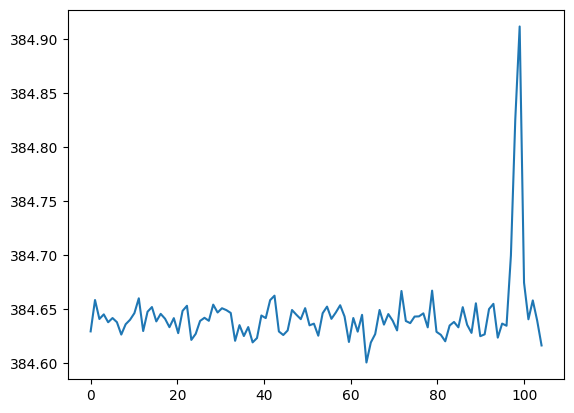

In [13]:
print(s1_0)

# Crea un array di valori x
x = np.linspace(0, 104, 104)  # da -10 a 10 con 400 punti
# Calcola i corrispondenti valori y della funzione f(x)
# Traccia la curva
plt.plot(x, s1_0)

[0.11526848 0.11905433 0.10721119 0.11807858 0.11653088 0.12345913
 0.11309944 0.11336501 0.11664735 0.11348354 0.11372095 0.11050635
 0.11442382 0.11660181 0.11587651 0.11988788 0.11911572 0.11659989
 0.11602916 0.11536582 0.11576987 0.11976256 0.11834665 0.11432605
 0.11534862 0.11238457 0.11536573 0.11799523 0.12015338 0.11708369
 0.12444975 0.11609225 0.12038036 0.11370054 0.11782161 0.11370545
 0.11410436 0.11721026 0.11508283 0.116408   0.11811804 0.10771125
 0.11937683 0.11463414 0.11446252 0.10682473 0.12500983 0.11738832
 0.11801321 0.1139186  0.11255611 0.11967767 0.11449815 0.11867088
 0.11523262 0.11575326 0.11438008 0.11663178 0.11443974 0.11329238
 0.11426669 0.11487217 0.11453044 0.1133554  0.11422934 0.11299161
 0.11474106 0.11322279 0.11801551 0.11273715 0.10525246 0.11937932
 0.12073983 0.11570159 0.11402679 0.11937915 0.11814097 0.11589157
 0.11865395 0.112814   0.10929651 0.11209523 0.11595032 0.12037716
 0.11275244 0.11401941 0.11158413 0.11284162 0.12410693 0.1144

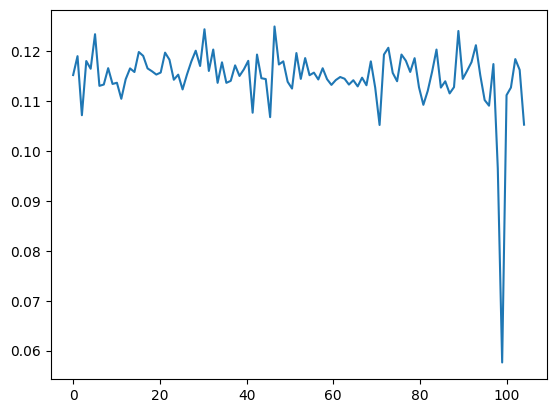

In [16]:
print(s2_0)

# Crea un array di valori x
x = np.linspace(0, 104, 104)  # da -10 a 10 con 400 punti
# Calcola i corrispondenti valori y della funzione f(x)
# Traccia la curva
plt.plot(x, s2_0)

[-0.77236777 -0.74336663 -0.76091064 -0.7566581  -0.76393035 -0.76003561
 -0.7638453  -0.77530794 -0.76576653 -0.76163991 -0.75547986 -0.74178596
 -0.77206567 -0.75418894 -0.74987508 -0.76314054 -0.75616859 -0.76068184
 -0.7684796  -0.76013298 -0.77400461 -0.75341457 -0.74869879 -0.78023122
 -0.7746343  -0.76271083 -0.75980711 -0.76256968 -0.74763762 -0.75492116
 -0.75097638 -0.75270663 -0.75531476 -0.78108399 -0.76659823 -0.77665698
 -0.7683864  -0.78253217 -0.77851491 -0.75768536 -0.76009314 -0.74350847
 -0.73935159 -0.77244622 -0.77572302 -0.77152396 -0.75260375 -0.75699453
 -0.76106613 -0.75089744 -0.76677162 -0.76522039 -0.77635614 -0.75557251
 -0.74946287 -0.76077764 -0.75492695 -0.74820067 -0.75860687 -0.7821651
 -0.76001438 -0.77261334 -0.75705769 -0.80110706 -0.78265748 -0.77485221
 -0.75257776 -0.76610194 -0.75636115 -0.76251351 -0.77147388 -0.73503106
 -0.76275751 -0.76474384 -0.75867299 -0.75848936 -0.75570445 -0.7686501
 -0.73471543 -0.77275277 -0.77558263 -0.78152769 -0.7

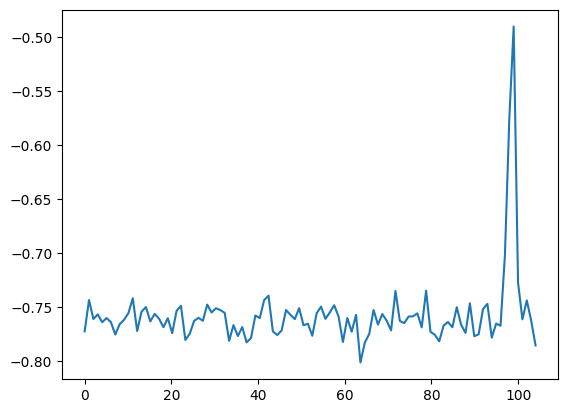

In [18]:
print(s3_0)

# Crea un array di valori x
x = np.linspace(0, 104, 104)  # da -10 a 10 con 400 punti
# Calcola i corrispondenti valori y della funzione f(x)
# Traccia la curva
plt.plot(x, s3_0)

[0.84369452 0.8195415  0.8283696  0.83102952 0.83673201 0.83732507
 0.83460114 0.84526175 0.83847822 0.83281384 0.82732748 0.812867
 0.84291709 0.82789055 0.82352241 0.83801633 0.83120795 0.83380858
 0.84058911 0.8325671  0.8454898  0.82909352 0.82395177 0.85034511
 0.84581731 0.83313407 0.83226953 0.8363658  0.82408458 0.82884839
 0.82970794 0.82623213 0.83119237 0.85076009 0.83993717 0.84670037
 0.8393581  0.85414686 0.84921628 0.83096035 0.83418201 0.81272141
 0.81609902 0.84339037 0.84629116 0.83789853 0.83151803 0.8309206
 0.8350059  0.82326518 0.83695569 0.83978564 0.84689256 0.83039791
 0.82275586 0.8333882  0.82722112 0.82245731 0.83061672 0.85151313
 0.83179837 0.8436845  0.82925677 0.86898097 0.85251514 0.84462273
 0.82529652 0.83674068 0.83072119 0.83316505 0.83691362 0.81218839
 0.8381759  0.83697953 0.8304285  0.83347781 0.83019888 0.84066316
 0.81145592 0.84259174 0.84310434 0.85022394 0.83915247 0.83877075
 0.83875569 0.82248459 0.83590801 0.84352453 0.82538513 0.8473164

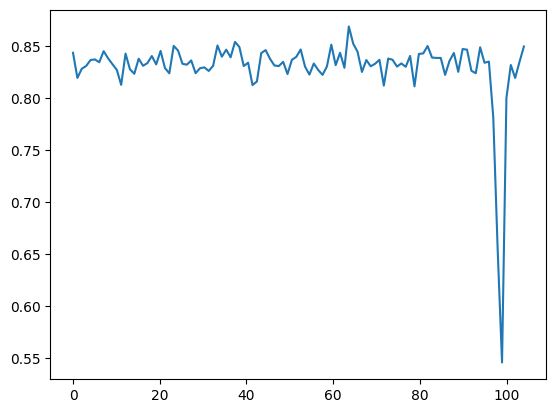

In [20]:
print(s4_0)

# Crea un array di valori x
x = np.linspace(0, 104, 104)  # da -10 a 10 con 400 punti
# Calcola i corrispondenti valori y della funzione f(x)
# Traccia la curva
plt.plot(x, s4_0)